# Find solutions to the equation for a damped harmonic oscillator with DeepXDE

By Allan P. Engsig-Karup (apek@dtu.dk)
November 25, 2021

In this notebook, we sample in the parameter domain (t) and learn (discover) the solution(s) to the equation for a damped harmnic oscillator and demonstrate how to generalize the trained model using a PINN approach.

In [ ]:
# References
# http://hyperphysics.phy-astr.gsu.edu/hbase/oscda.html
# https://web.northeastern.edu/afeiguin/p4840/p131spring04/node33.html

Install packages (run only once in the runtime)

In [1]:
!pip install deepxde

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


Imports and functions

In [2]:
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


# Damped oscillator equation - recover solution without using labels

 $x'' = -\omega_0^2x-\gamma x'$, $t>0$

 $v=x'$
 
 $x(t_0) = 1$, $v(t_0)=0$
 
 $\omega_0^2=9$, $\gamma=0.5$ 

Compiling model...
Building feed-forward neural network...
'build' took 0.062713 s

'compile' took 1.229083 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.87e-02, 1.85e+00, 1.00e+00, 0.00e+00]    [1.87e-02, 1.85e+00, 0.00e+00, 0.00e+00]    []  
1000      [1.00e-01, 1.89e-02, 3.84e-02, 4.50e-07]    [1.00e-01, 1.89e-02, 0.00e+00, 0.00e+00]    []  
2000      [6.41e-02, 8.33e-03, 7.70e-03, 7.94e-08]    [6.41e-02, 8.33e-03, 0.00e+00, 0.00e+00]    []  
3000      [4.05e-02, 5.30e-03, 3.08e-03, 3.60e-09]    [4.05e-02, 5.30e-03, 0.00e+00, 0.00e+00]    []  
4000      [3.30e-02, 4.82e-03, 2.22e-03, 1.02e-06]    [3.30e-02, 4.82e-03, 0.00e+00, 0.00e+00]    []  
5000      [2.47e-02, 3.24e-03, 1.06e-03, 3.79e-06]    [2.47e-02, 3.24e-03, 0.00e+00, 0.00e+00]    []  
6000      [2.10e-02, 2.24e-03, 6.08e-04, 2.76e-07]    [2.10e-02, 2.24e-03, 0.00e+00, 0.00e+00]    []  
7000      [1.

77000     [4.42e-05, 3.00e-05, 3.91e-08, 2.45e-07]    [4.42e-05, 3.00e-05, 0.00e+00, 0.00e+00]    []  
78000     [4.38e-05, 6.54e-05, 4.56e-08, 1.99e-07]    [4.38e-05, 6.54e-05, 0.00e+00, 0.00e+00]    []  
79000     [6.36e-05, 1.44e-03, 7.85e-07, 1.64e-05]    [6.36e-05, 1.44e-03, 0.00e+00, 0.00e+00]    []  
80000     [6.24e-05, 5.38e-04, 6.92e-06, 9.85e-06]    [6.24e-05, 5.38e-04, 0.00e+00, 0.00e+00]    []  

Best model at step 73000:
  train loss: 7.23e-05
  test loss: 7.22e-05
  test metric: []

'train' took 72.801809 s

Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...


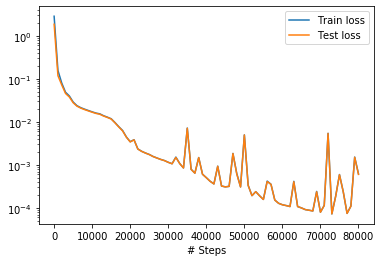

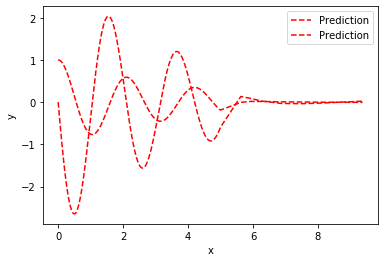

Predicting...
'predict' took 0.290200 s



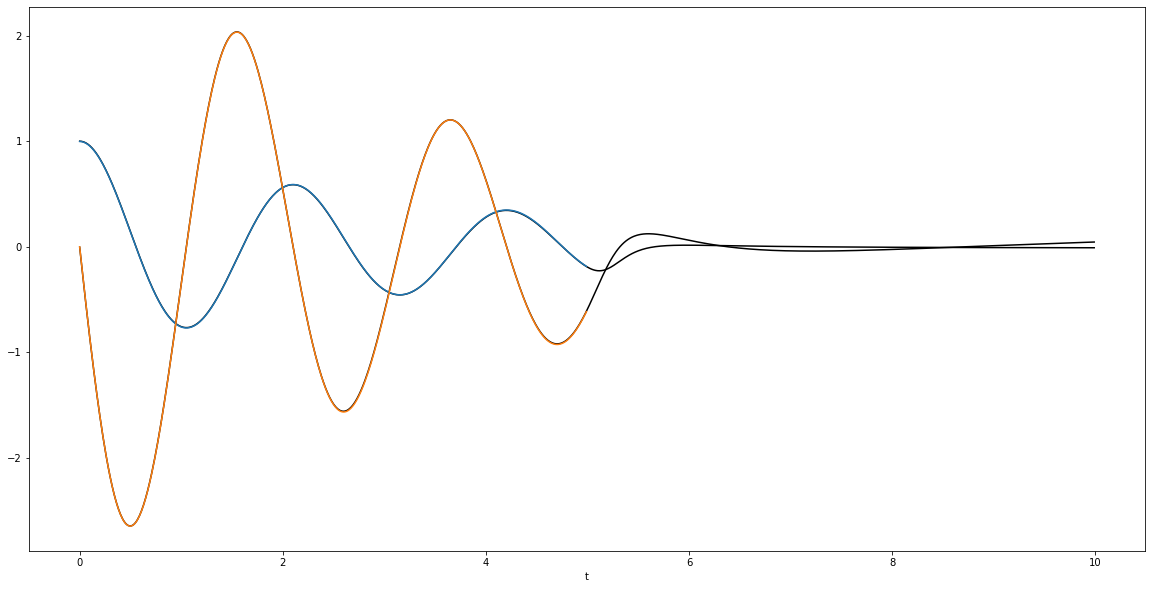

In [117]:
gamma   = 0.5  # model parameter
omega0  = 3    # model parameter
tfinal  = 10.0 # final time
x0      = 1.0  # initial condition, position
v0      = 0.0  # initial condition, velocity

def boundary(_, on_initial):
    return on_initial

# Equation system definition
def testequation(t,z):
    z0, z1 = z[:,0:1], z[:,1:2]
    dz0_t = dde.grad.jacobian(z, t, i=0) # x(t) 
    dz1_t = dde.grad.jacobian(z, t, i=1) # v(t)
    return [
        dz0_t - z1,
        dz1_t + omega0**2*z0 + gamma*z1,
    ]

# Equation model definition, rhs side for ODE solver
def testeq(z, t):
    return [
      z[1],
      -omega0**2*z[0] - gamma*z[1],
    ]

# define time domain
geom = dde.geometry.TimeDomain(0, tfinal)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: v0, boundary, component=1)

# Get the training data
dt = 0.01
t_train = np.arange(0, tfinal/2, dt)
observe_t = t_train
z_train = odeint(testeq, [x0, v0], t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE
observe_z = z_train

# Get the training data
observe_z0 = dde.PointSetBC(observe_t, observe_z[:, 0:1], component=0)
observe_z1 = dde.PointSetBC(observe_t, observe_z[:, 1:2], component=1)

# define data object
data = dde.data.PDE(
    geom,
    testequation,
    [ic1, ic2 ],
    num_domain=20,
    num_boundary=1,
    anchors=np.reshape(observe_t,(len(observe_t),1)),
)

# define FNN architecture and compile
net = dde.maps.FNN([1] + [20] * 3 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(epochs=80000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

t_train2 = np.arange(0, tfinal, dt)
observe_t2 = t_train2
yhat = model.predict(np.reshape(observe_t2,(-1,1)))

fig = plt.figure(figsize=(20,10))
##plt.plot(t_train, x_train1)
##plt.plot([tfinal, tfinal],[0.0, 1.0],'k--')
plt.plot(observe_t2, yhat,'k')
plt.plot(observe_t, observe_z)
plt.xlabel('t')
#plt.ylabel('z(t)')
#plt.legend(['Ground truth','Prediction'])
#plt.title('Test equation')
plt.show()

In [123]:
np.shape(np.reshape(observe_t,(-1,1)))

(500, 1)

# Damped oscillator equation - recover solution using labels

 $x'' = -\omega_0^2x-\gamma x'$, $t>0$

 $v=x'$
 
 $x(t_0) = 1$, $v(t_0)=0$
 
 $\omega_0^2=9$, $\gamma=0.5$ 

Compiling model...
Building feed-forward neural network...
'build' took 0.059165 s

'compile' took 1.109263 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.55e-01, 2.95e+00, 1.00e+00, 0.00e+00, 2.26e-01, 1.79e+00]    [2.55e-01, 2.95e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [4.48e-02, 2.64e-02, 6.04e-05, 8.37e-05, 5.79e-02, 5.21e-01]    [4.48e-02, 2.64e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [2.69e-02, 2.02e-02, 1.75e-06, 1.57e-06, 2.07e-02, 1.57e-01]    [2.69e-02, 2.02e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [2.65e-02, 1.04e-02, 9.49e-06, 2.82e-05, 4.28e-03, 1.62e-02]    [2.65e-02, 1.04e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4000      [1.92e-02, 2.55e-03, 1.24e-08, 6.75e-09, 2.42e-03, 8.14e-03]    [1.92e-02, 2.55e-03, 0.00e+00, 0.00e+00, 0.00e+0

56000     [5.30e-04, 4.78e-05, 6.69e-10, 6.60e-11, 1.36e-06, 3.41e-06]    [5.30e-04, 4.78e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
57000     [5.21e-04, 4.63e-05, 5.74e-10, 2.95e-09, 1.31e-06, 3.13e-06]    [5.21e-04, 4.63e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
58000     [5.13e-04, 4.57e-05, 3.20e-14, 5.96e-09, 1.29e-06, 2.99e-06]    [5.13e-04, 4.57e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
59000     [5.05e-04, 4.55e-05, 1.62e-09, 2.40e-09, 1.22e-06, 2.85e-06]    [5.05e-04, 4.55e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
60000     [4.97e-04, 7.12e-05, 8.35e-08, 3.95e-06, 1.65e-06, 3.62e-06]    [4.97e-04, 7.12e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
61000     [4.88e-04, 9.79e-05, 2.03e-08, 1.66e-05, 2.16e-06, 6.88e-06]    [4.88e-04, 9.79e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
62000     [4.79e-04, 5.82e-05, 2.29e-08, 2.81e-06, 1.46e-06, 3.34e-06]    [4.79e-04, 5.82e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

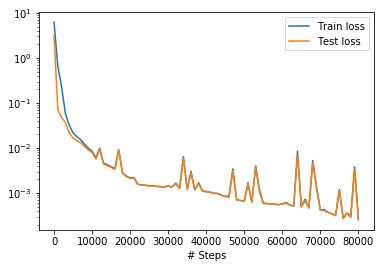

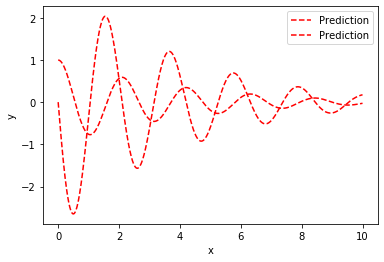

Predicting...
'predict' took 0.343673 s



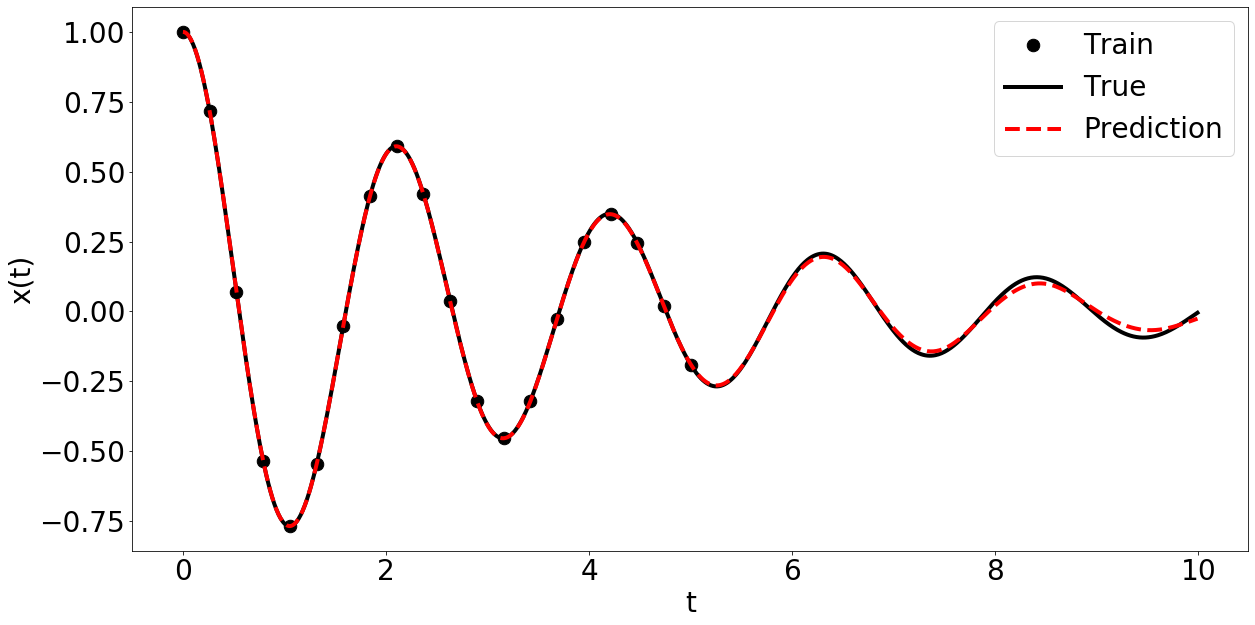

In [159]:
gamma   = 0.5  # model parameter
omega0  = 3    # model parameter
tfinal  = 10.0 # final time
x0      = 1.0  # initial condition, position
v0      = 0.0  # initial condition, velocity

def boundary(_, on_initial):
    return on_initial

# Equation system definition
def testequation(t,z):
    z0, z1 = z[:,0:1], z[:,1:2]
    dz0_t = dde.grad.jacobian(z, t, i=0) # x(t) 
    dz1_t = dde.grad.jacobian(z, t, i=1) # v(t)
    return [
        dz0_t - z1,
        dz1_t + omega0**2*z0 + gamma*z1,
    ]

# Equation model definition, rhs side for ODE solver
def testeq(z, t):
    return [
      z[1],
      -omega0**2*z[0] - gamma*z[1],
    ]

# define time domain
geom = dde.geometry.TimeDomain(0, tfinal)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: v0, boundary, component=1)

# Get the training data
dt = 0.01
t_train = np.linspace(0,tfinal/2,20) #np.arange(0, tfinal/2, dt)
observe_t = t_train
z_train = odeint(testeq, [x0, v0], t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE
observe_z = z_train
observe_t = np.reshape(observe_t,(-1,1))

# Get the training data
observe_z0 = dde.PointSetBC(observe_t, observe_z[:, 0:1], component=0)
observe_z1 = dde.PointSetBC(observe_t, observe_z[:, 1:2], component=1)

# define data object
data = dde.data.PDE(
    geom,
    testequation,
    [ic1, ic2, observe_z0, observe_z1 ],
    num_domain=1000,
    num_boundary=1,
    anchors=np.reshape(observe_t,(len(observe_t),1)),
)

# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 4 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(epochs=80000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

t_train2 = np.arange(0, tfinal, dt)
observe_t2 = t_train2
yhat = model.predict(np.reshape(observe_t2,(-1,1)))

z_true = odeint(testeq, [x0, v0], t_train2)

fig = plt.figure(figsize=(20,10))
##plt.plot(t_train, x_train1)
##plt.plot([tfinal, tfinal],[0.0, 1.0],'k--')
plt.plot(observe_t, observe_z[:,0],'k.',markersize=25,label='Train')
plt.plot(observe_t2, z_true[:,0],'k-',linewidth=4,label='True')
plt.plot(observe_t2, yhat[:,0],'r--',linewidth=4,label='Prediction')
plt.xlabel('t',fontsize=28)
plt.ylabel('x(t)',fontsize=28)
#plt.ylabel('z(t)')
#plt.legend(['Ground truth','Prediction'])
#plt.title('Test equation')
plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()


# Damped oscillator equation - recover solution without labels

Compiling model...
Building feed-forward neural network...
'build' took 1.028691 s

'compile' took 7.607742 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.71e-01, 3.21e+01, 1.00e+00, 0.00e+00]    [2.71e-01, 3.21e+01, 0.00e+00, 0.00e+00]    []  
1000      [9.27e-02, 1.77e-02, 2.21e-02, 4.81e-06]    [9.27e-02, 1.77e-02, 0.00e+00, 0.00e+00]    []  
2000      [5.40e-02, 8.53e-03, 5.94e-03, 1.60e-06]    [5.40e-02, 8.53e-03, 0.00e+00, 0.00e+00]    []  
3000      [4.29e-02, 4.65e-03, 3.06e-03, 1.43e-07]    [4.29e-02, 4.65e-03, 0.00e+00, 0.00e+00]    []  
4000      [3.31e-02, 4.01e-03, 1.89e-03, 1.42e-06]    [3.31e-02, 4.01e-03, 0.00e+00, 0.00e+00]    []  
5000      [2.64e-02, 3.24e-03, 1.11e-03, 1.46e-07]    [2.64e-02, 3.24e-03, 0.00e+00, 0.00e+00]    []  
6000      [2.26e-02, 2.93e-03, 7.77e-04, 6.57e-08]    [2.26e-02, 2.93e-03, 0.00e+00, 0.00e+00]    []  
7000      [1.

77000     [5.09e-04, 5.39e-05, 5.32e-07, 2.05e-07]    [5.09e-04, 5.39e-05, 0.00e+00, 0.00e+00]    []  
78000     [5.24e-04, 1.46e-04, 7.48e-06, 6.29e-05]    [5.24e-04, 1.46e-04, 0.00e+00, 0.00e+00]    []  
79000     [4.95e-04, 1.40e-04, 3.08e-06, 1.41e-06]    [4.95e-04, 1.40e-04, 0.00e+00, 0.00e+00]    []  
80000     [4.83e-04, 8.90e-05, 1.42e-06, 4.15e-06]    [4.83e-04, 8.90e-05, 0.00e+00, 0.00e+00]    []  

Best model at step 77000:
  train loss: 5.63e-04
  test loss: 5.63e-04
  test metric: []

'train' took 227.487468 s

Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...


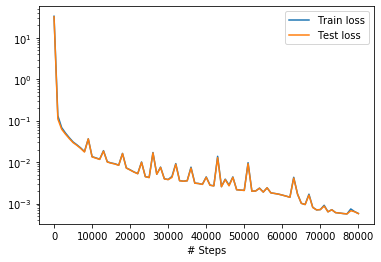

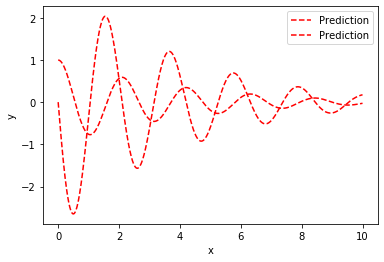

Predicting...
'predict' took 0.580837 s



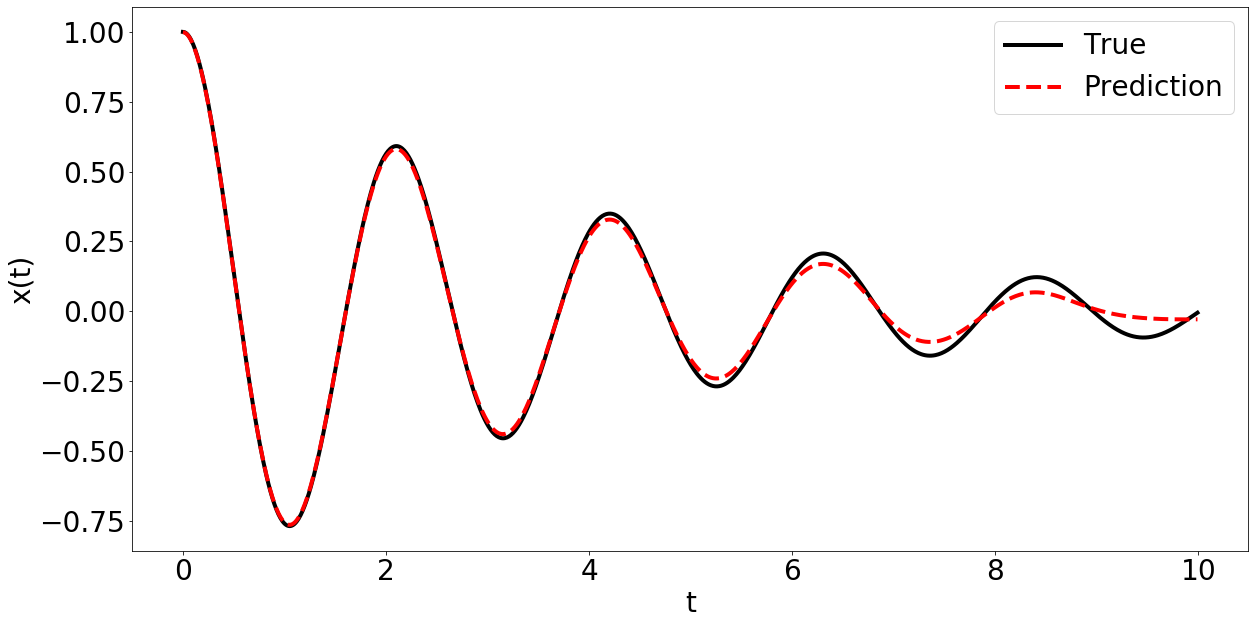

In [199]:
gamma   = 0.5  # model parameter
omega0  = 3    # model parameter
tfinal  = 10.0 # final time
x0      = 1.0  # initial condition, position
v0      = 0.0  # initial condition, velocity

def boundary(_, on_initial):
    return on_initial

# Equation system definition
def dhomodel(t,z):
    z0, z1 = z[:,0:1], z[:,1:2]
    dz0_t = dde.grad.jacobian(z, t, i=0) # x(t) 
    dz1_t = dde.grad.jacobian(z, t, i=1) # v(t)
    return [
        dz0_t - z1,
        dz1_t + omega0**2*z0 + gamma*z1,
    ]

# Equation model definition, rhs side for ODE solver
def dhomodelODE(z, t):
    return [
      z[1],
      -omega0**2*z[0] - gamma*z[1],
    ]

# define time domain
geom = dde.geometry.TimeDomain(0, tfinal)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: v0, boundary, component=1)

# Get the training data
dt = 0.01
t_train = np.linspace(0,tfinal/2,20) #np.arange(0, tfinal/2, dt)
observe_t = t_train
z_train = odeint(dhomodelODE, [x0, v0], t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE
observe_z = z_train
observe_t = np.reshape(observe_t,(-1,1))

# Get the training data
observe_z0 = dde.PointSetBC(observe_t, observe_z[:, 0:1], component=0)
observe_z1 = dde.PointSetBC(observe_t, observe_z[:, 1:2], component=1)

# define data object
data = dde.data.PDE(
    geom,
    dhomodel,
    [ic1, ic2], #, observe_z0, observe_z1 ],
    num_domain=1000,
    num_boundary=1,
    #anchors=np.reshape(observe_t,(len(observe_t),1)),
)

# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 4 + [2], "tanh", "Glorot uniform")
model2 = dde.Model(data, net)
model2.compile("adam", lr=0.001)

losshistory2, train_state2 = model2.train(epochs=80000)

dde.saveplot(losshistory2, train_state, issave=True, isplot=True)

t_train2 = np.arange(0, tfinal, dt)
observe_t2 = t_train2
yhat = model2.predict(np.reshape(observe_t2,(-1,1)))

z_true = odeint(testeq, [x0, v0], t_train2)

fig = plt.figure(figsize=(20,10))
##plt.plot(t_train, x_train1)
##plt.plot([tfinal, tfinal],[0.0, 1.0],'k--')
#plt.plot(observe_t, observe_z[:,0],'k.',markersize=25,label='Train')
plt.plot(observe_t2, z_true[:,0],'k-',linewidth=4,label='True')
plt.plot(observe_t2, yhat[:,0],'r--',linewidth=4,label='Prediction')
plt.xlabel('t',fontsize=28)
plt.ylabel('x(t)',fontsize=28)
#plt.ylabel('z(t)')
#plt.legend(['Ground truth','Prediction'])
#plt.title('Test equation')
plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()



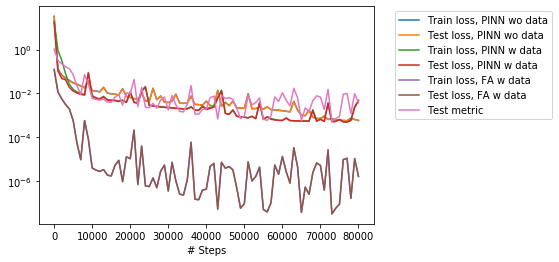

In [210]:
loss_history = losshistory2

loss_train = np.sum(loss_history.loss_train, axis=1)
loss_test = np.sum(loss_history.loss_test, axis=1)
plt.figure()
plt.semilogy(loss_history.steps, loss_train, label="Train loss, PINN wo data")
plt.semilogy(loss_history.steps, loss_test, label="Test loss, PINN wo data")
for i in range(len(loss_history.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("# Steps")


loss_history = losshistory3

loss_train = np.sum(loss_history.loss_train, axis=1)
loss_test = np.sum(loss_history.loss_test, axis=1)
plt.semilogy(loss_history.steps, loss_train, label="Train loss, PINN w data")
plt.semilogy(loss_history.steps, loss_test, label="Test loss, PINN w data")
for i in range(len(loss_history.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("# Steps")


loss_history = losshistory4

loss_train = np.sum(loss_history.loss_train, axis=1)
loss_test = np.sum(loss_history.loss_test, axis=1)
plt.semilogy(loss_history.steps, loss_train, label="Train loss, FA w data")
plt.semilogy(loss_history.steps, loss_test, label="Test loss, FA w data")
for i in range(len(loss_history.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("# Steps")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


# Damped oscillator equation - recover solution with labels II

Compiling model...
Building feed-forward neural network...
'build' took 0.261091 s

'compile' took 2.506600 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.86e-01, 1.68e+01, 1.00e+00, 0.00e+00, 3.43e-01, 1.68e+00]    [1.86e-01, 1.68e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.81e-02, 4.62e-02, 8.65e-04, 7.78e-04, 8.48e-02, 7.35e-01]    [5.81e-02, 4.62e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [3.04e-02, 1.73e-02, 5.93e-06, 5.23e-05, 2.65e-02, 2.56e-01]    [3.04e-02, 1.73e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [3.49e-02, 7.10e-03, 3.06e-06, 4.46e-06, 5.37e-03, 3.13e-02]    [3.49e-02, 7.10e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4000      [1.56e-02, 2.98e-03, 8.68e-07, 1.47e-07, 1.57e-03, 5.76e-03]    [1.56e-02, 2.98e-03, 0.00e+00, 0.00e+00, 0.00e+0

56000     [5.61e-04, 2.79e-04, 2.22e-06, 2.87e-07, 2.95e-06, 4.80e-06]    [5.61e-04, 2.79e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
57000     [5.40e-04, 1.10e-04, 1.68e-08, 3.38e-05, 2.17e-06, 1.80e-05]    [5.40e-04, 1.10e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
58000     [5.27e-04, 7.99e-05, 9.83e-08, 7.96e-06, 1.63e-06, 1.49e-05]    [5.27e-04, 7.99e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
59000     [5.12e-04, 6.95e-05, 1.12e-09, 4.01e-10, 1.16e-06, 3.67e-06]    [5.12e-04, 6.95e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
60000     [5.03e-04, 7.11e-05, 3.92e-10, 2.78e-08, 1.11e-06, 3.44e-06]    [5.03e-04, 7.11e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
61000     [5.09e-04, 2.12e-04, 1.73e-06, 2.36e-05, 3.52e-06, 6.65e-06]    [5.09e-04, 2.12e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
62000     [4.91e-04, 7.75e-05, 6.82e-09, 1.02e-06, 1.15e-06, 3.67e-06]    [4.91e-04, 7.75e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

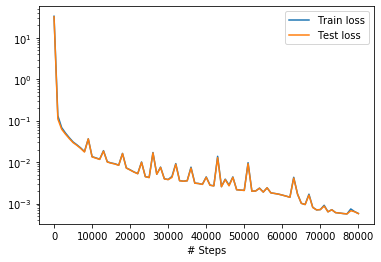

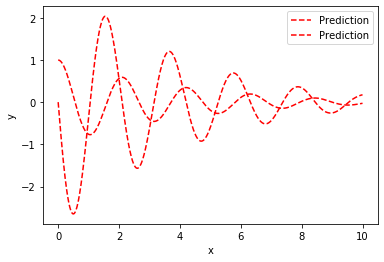

Predicting...
'predict' took 0.394925 s



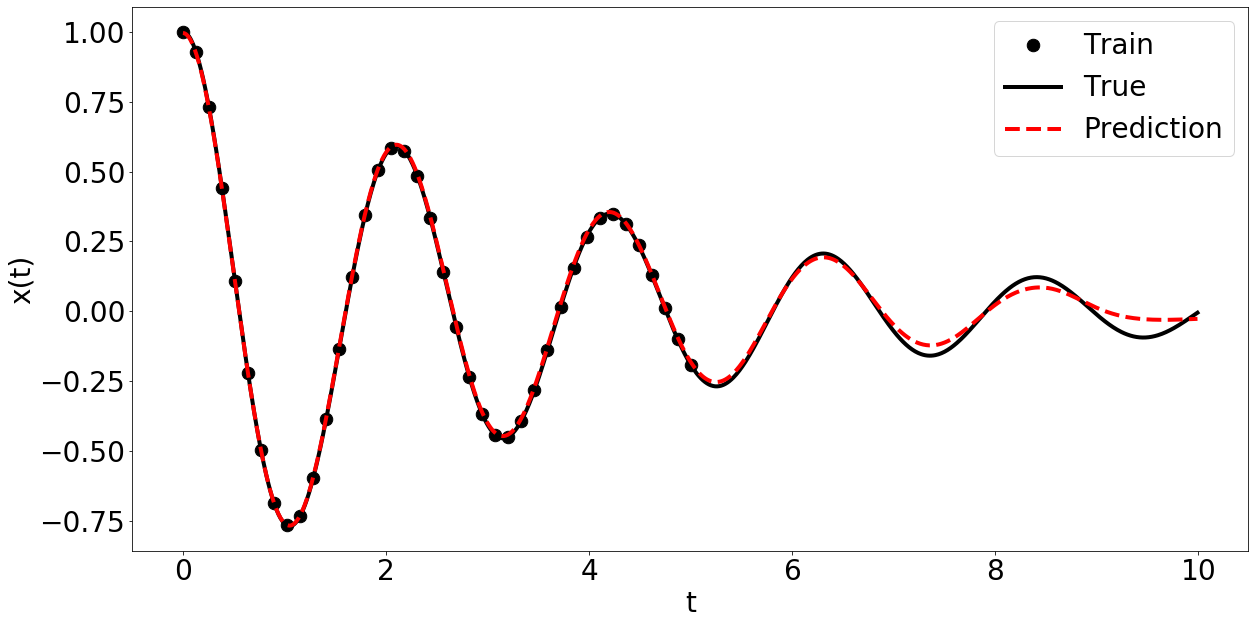

In [200]:
gamma   = 0.5  # model parameter
omega0  = 3    # model parameter
tfinal  = 10.0 # final time
x0      = 1.0  # initial condition, position
v0      = 0.0  # initial condition, velocity

def boundary(_, on_initial):
    return on_initial

# Equation system definition
def testequation(t,z):
    z0, z1 = z[:,0:1], z[:,1:2]
    dz0_t = dde.grad.jacobian(z, t, i=0) # x(t) 
    dz1_t = dde.grad.jacobian(z, t, i=1) # v(t)
    return [
        dz0_t - z1,
        dz1_t + omega0**2*z0 + gamma*z1,
    ]

# Equation model definition, rhs side for ODE solver
def testeq(z, t):
    return [
      z[1],
      -omega0**2*z[0] - gamma*z[1],
    ]

# define time domain
geom = dde.geometry.TimeDomain(0, tfinal)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: v0, boundary, component=1)

# Get the training data
dt = 0.01
t_train = np.linspace(0,tfinal/2,40) #np.arange(0, tfinal/2, dt)
observe_t = t_train
z_train = odeint(testeq, [x0, v0], t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE
observe_z = z_train
observe_t = np.reshape(observe_t,(-1,1))

# Get the training data
observe_z0 = dde.PointSetBC(observe_t, observe_z[:, 0:1], component=0)
observe_z1 = dde.PointSetBC(observe_t, observe_z[:, 1:2], component=1)

# define data object
data = dde.data.PDE(
    geom,
    testequation,
    [ic1, ic2, observe_z0, observe_z1 ],
    num_domain=1000,
    num_boundary=1,
    anchors=np.reshape(observe_t,(len(observe_t),1)),
)

# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 4 + [2], "tanh", "Glorot uniform")
model3 = dde.Model(data, net)
model3.compile("adam", lr=0.001)

losshistory3, train_state3 = model3.train(epochs=80000)

dde.saveplot(losshistory3, train_state3, issave=True, isplot=True)

t_train2 = np.arange(0, tfinal, dt)
observe_t2 = t_train2
yhat = model3.predict(np.reshape(observe_t2,(-1,1)))

z_true = odeint(testeq, [x0, v0], t_train2)

fig = plt.figure(figsize=(20,10))
##plt.plot(t_train, x_train1)
##plt.plot([tfinal, tfinal],[0.0, 1.0],'k--')
plt.plot(observe_t, observe_z[:,0],'k.',markersize=25,label='Train')
plt.plot(observe_t2, z_true[:,0],'k-',linewidth=4,label='True')
plt.plot(observe_t2, yhat[:,0],'r--',linewidth=4,label='Prediction')
plt.xlabel('t',fontsize=28)
plt.ylabel('x(t)',fontsize=28)
#plt.ylabel('z(t)')
plt.legend(['Train','Ground truth','Prediction'])
#plt.title('Test equation')
plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()



Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...


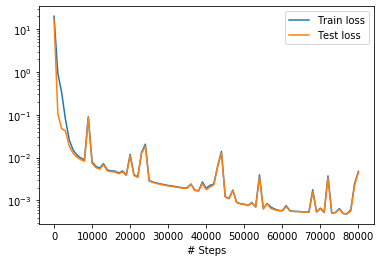

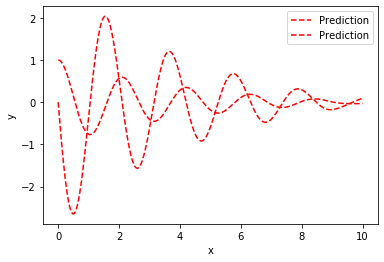

In [201]:
dde.saveplot(losshistory3, train_state3, issave=True, isplot=True)



Predicting...
'predict' took 0.855394 s



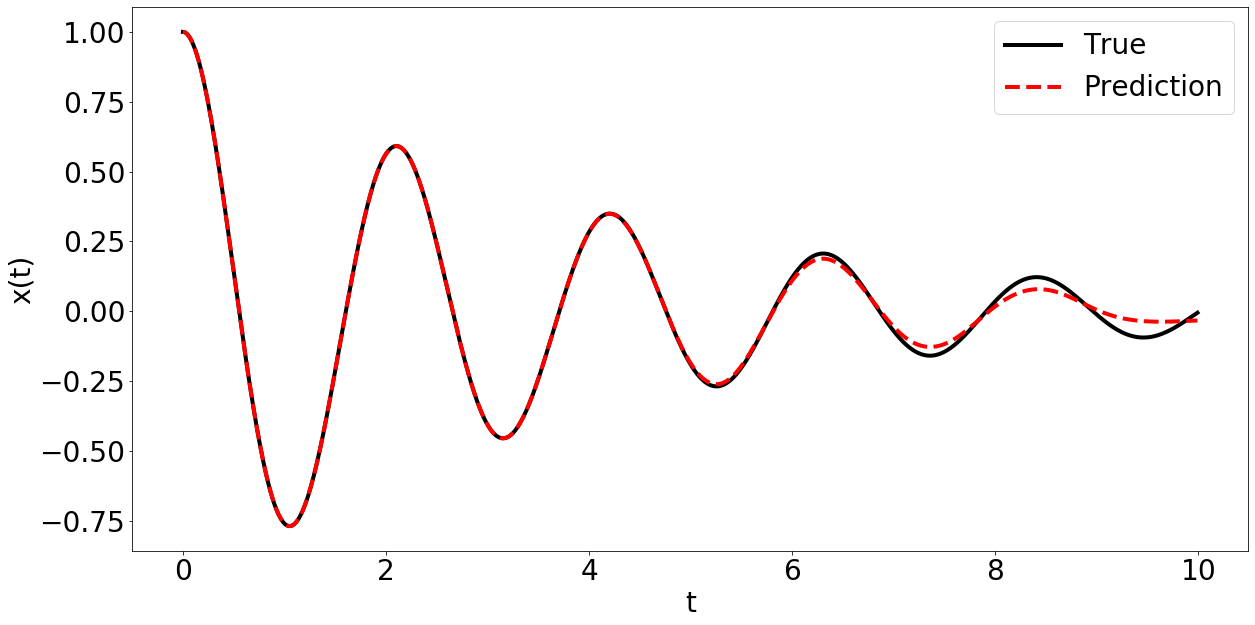

In [173]:
t_train2 = np.arange(0, tfinal, dt)
observe_t2 = t_train2
yhat = model3.predict(np.reshape(observe_t2,(-1,1)))

z_true = odeint(testeq, [x0, v0], t_train2)

fig = plt.figure(figsize=(20,10))
##plt.plot(t_train, x_train1)
##plt.plot([tfinal, tfinal],[0.0, 1.0],'k--')
#plt.plot(observe_t, observe_z[:,0],'k.',markersize=25,label='Train')
plt.plot(observe_t2, z_true[:,0],'k-',linewidth=4,label='True')
plt.plot(observe_t2, yhat[:,0],'r--',linewidth=4,label='Prediction')
plt.xlabel('t',fontsize=28)
plt.ylabel('x(t)',fontsize=28)
#plt.ylabel('z(t)')
#plt.legend(['Ground truth','Prediction'])
#plt.title('Test equation')
plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()

# Data-driven function approximation

Compiling model...
Building feed-forward neural network...
'build' took 0.088586 s

'compile' took 11.436912 s

Initializing variables...
Training model...

0         [1.23e-01]    [1.23e-01]    [1.05e+00]    
1000      [1.16e-02]    [1.16e-02]    [3.21e-01]    
2000      [5.61e-03]    [5.61e-03]    [2.24e-01]    
3000      [3.08e-03]    [3.08e-03]    [1.66e-01]    
4000      [1.93e-03]    [1.93e-03]    [1.31e-01]    
5000      [5.77e-04]    [5.77e-04]    [7.18e-02]    
6000      [5.32e-05]    [5.32e-05]    [2.18e-02]    
7000      [9.22e-06]    [9.22e-06]    [9.07e-03]    
8000      [5.69e-04]    [5.69e-04]    [7.12e-02]    
9000      [8.01e-05]    [8.01e-05]    [2.67e-02]    
10000     [3.88e-06]    [3.88e-06]    [5.88e-03]    
11000     [3.10e-06]    [3.10e-06]    [5.26e-03]    
12000     [2.68e-06]    [2.68e-06]    [4.89e-03]    
13000     [3.25e-06]    [3.25e-06]    [5.38e-03]    
14000     [1.82e-06]    [1.82e-06]    [4.03e-03]    
15000     [1.66e-06]    [1.66e-06]    [3.85e-03]

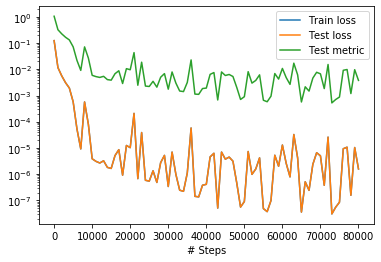

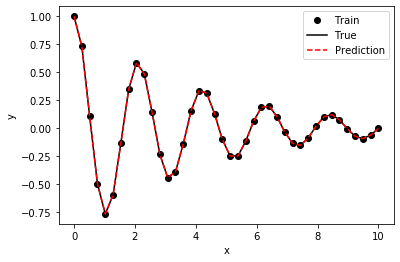

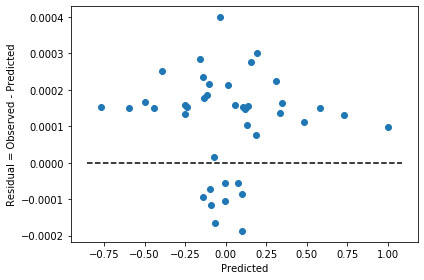

In [205]:
# Get the training data
dt = 0.01
t_train = np.linspace(0,tfinal,40) #np.arange(0, tfinal/2, dt)
observe_t = t_train
z_train = odeint(testeq, [x0, v0], t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE
observe_z = z_train
observe_t = np.reshape(observe_t,(-1,1))

X = t_train
y = observe_z[:,0]

X_train = np.concatenate((np.reshape(X,(-1,1)), np.reshape(y,(-1,1))),axis=1)
#fname_test  = np.concatenate((np.reshape(X,(-1,1)), np.reshape(y,(-1,1))),axis=1)

# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(X, (-1, 1)),
    y_test=np.reshape(y, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
    # standardize=True,
)

layer_size = [1] + [40] * 4 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory4, train_state4 = model.train(epochs=80000)

dde.saveplot(losshistory4, train_state4, issave=True, isplot=True)

Predicting...
'predict' took 0.002209 s



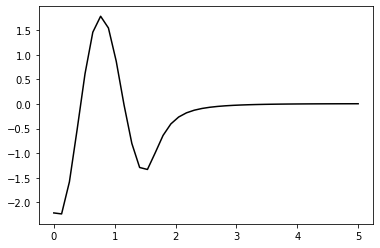

In [198]:
# compute gradient of solution
def dzdt(t, z):
    return dde.grad.jacobian(z, t, i=0)
dz_dt = model.predict(X, operator=dzdt)

plt.figure()
plt.plot(observe_t,dz_dt,'k')
plt.show()